You are a Data Analyst at a travel research firm tasked with analyzing Airbnb activity in Asheville, NC. Your goal is to evaluate pricing, demand and host activity trends to help a travel startup decide whether to expand services in Asheville.

1) What pricing trends look like?
2) Which neighborhoods and hosts are most active?
3) What review activity says about demand?

## 1) Data Preparation


In [2]:
# Loading libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [3]:
# Load the listings data
listings = pd.read_csv("listings.csv")

listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.578640,-82.595780,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,NaN
1,197263,Tranquil Room & Private Bath,961396,Timothy,NaN,28806,35.577350,-82.638040,Private room,44.0,2,87,2024-09-08,0.56,2,73,5,NaN
2,209068,Terrace Cottage,1029919,Kevin,NaN,28804,35.617641,-82.551819,Entire home/apt,90.0,30,67,2025-05-03,0.40,1,268,2,NaN
3,246315,Asheville Dreamer's Cabin,1292070,Annie,NaN,28805,35.596150,-82.506350,Private room,61.0,7,53,2019-10-30,0.32,3,62,0,NaN
4,314540,Asheville Urban Farmhouse Entire Home 4.6 mi t...,381660,Tom,NaN,28806,35.585610,-82.627310,Entire home/apt,200.0,1,35,2025-06-13,0.22,1,139,11,NaN


In [4]:
# Check the shape
listings.shape

(2876, 18)

The dataset contains 2876 rows and 18 columns.

In [5]:
# Check the dtypes and null
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2876 entries, 0 to 2875
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              2876 non-null   int64  
 1   name                            2876 non-null   object 
 2   host_id                         2876 non-null   int64  
 3   host_name                       2876 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   2876 non-null   int64  
 6   latitude                        2876 non-null   float64
 7   longitude                       2876 non-null   float64
 8   room_type                       2876 non-null   object 
 9   price                           2536 non-null   float64
 10  minimum_nights                  2876 non-null   int64  
 11  number_of_reviews               2876 non-null   int64  
 12  last_review                     26

There are two main issues from the information above
1. Missing values in `last_review`, `price`, `reviews_per_month`.
2. Datatype mismatch for the `last_review` column. Appears as object instead of datetime. 

In [6]:
# Converting the last_review columns to datetime.

listings["last_review"] = pd.to_datetime(listings["last_review"])

# Checking dtypes to confirm changes
listings.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                      float64
neighbourhood                              int64
latitude                                 float64
longitude                                float64
room_type                                 object
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
number_of_reviews_ltm                      int64
license                                  float64
dtype: object

In [7]:
# Checking for the span of the last_review date. We will be needing the recent data to guide decision making.

earliest_last_review = listings["last_review"].min()
latest_last_review = listings["last_review"].max()

print(f"Earliest last review: {earliest_last_review}")
print(f"Latest last review: {latest_last_review}")

Earliest last review: 2015-10-03 00:00:00
Latest last review: 2025-06-16 00:00:00


In [8]:
# Filter for data from 2021 and keep listings without any reviews since they may be listings which are not yet reviewed.
recent_listings = listings.query("last_review >= '2021-01-01' or last_review.isna()").copy()

# Confirming the succes of the filtering
recent_listings["last_review"].min(), recent_listings["last_review"].max()

(Timestamp('2021-02-14 00:00:00'), Timestamp('2025-06-16 00:00:00'))

Even though the `last_review` date spans from 2015 to 2025, for this analysis, the focus will be on data from 2021 onwards, which reflects the most recent and stable market conditions following the COVID-19 pandemic. Properties with no reviews for years may be inactive, delisted or irrelevant to current market conditions, hence the exclusion of `last_review` date below 2021. Listing with `NaT` last_reviews were maintained because they may likely represent new unreviewed listings.

In [9]:
# Checking the shape of our working recent listings.
recent_listings.shape

(2852, 18)

In [10]:
# Drop possible duplicates if there are any
recent_listings = recent_listings.drop_duplicates()
recent_listings.shape

(2852, 18)

Comparing our filtered `recent_listings` dataset to the original `listings` dataset shows that 24 records were filtered out. `listings` had 2876 rows and `recent_listings` has 2852 rows. We did not lose much data from filtering.

In [11]:
# Finding the columns that contain null values.
missing_n = recent_listings.isna().sum()
missing_n[missing_n > 0]

neighbourhood_group    2852
price                   334
last_review             263
reviews_per_month       263
license                2852
dtype: int64

In [12]:
# Proportion of the columns that contain null values
missing_pct = recent_listings.isna().mean()
missing_pct[missing_pct > 0]

neighbourhood_group    1.000000
price                  0.117111
last_review            0.092216
reviews_per_month      0.092216
license                1.000000
dtype: float64

`neighbourhood_group` and `license` columns are entirely null.
Close to 12% of the `price` values are missing.
About 9% of the `last_revies` and `reviews_per_month` data are missing. These are likely new and unrewiewed listings.

In [13]:
# Drop the neighbourhood_group and license columns because they are all nulls.
recent_listings.dropna(how= "all",
                       axis=1,
                       inplace=True)

In [14]:
# View the columns to confirm the dropping of the groups.
recent_listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')

In [15]:
# Filling the missing price values with median
median_price = recent_listings["price"].median()
recent_listings["price"] = recent_listings["price"].fillna(median_price)

In [16]:
# Check for null to confirm
recent_listings.isna().sum()

id                                  0
name                                0
host_id                             0
host_name                           0
neighbourhood                       0
latitude                            0
longitude                           0
room_type                           0
price                               0
minimum_nights                      0
number_of_reviews                   0
last_review                       263
reviews_per_month                 263
calculated_host_listings_count      0
availability_365                    0
number_of_reviews_ltm               0
dtype: int64

## 2) Descriptive Analysis

With the data initially cleaned and prepared, I proceeded with some descriptive statistics. Further cleaning such as handling outliers was done.

In [17]:
# Check the summary statistics of the other numeric features of the listings
cols_of_interest = ["price", "minimum_nights" ,"number_of_reviews", "reviews_per_month",
                    "calculated_host_listings_count","availability_365","number_of_reviews_ltm"]
recent_listings[cols_of_interest].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2852.000000,2852.000000,2852.000000,2589.000000,2852.000000,2852.000000,2852.000000
mean,174.622370,5.789972,111.282258,2.185129,9.133240,224.873422,13.864656
std,207.996744,17.789635,154.858791,1.993351,21.953854,116.930660,18.331697
min,18.000000,1.000000,0.000000,0.020000,1.000000,0.000000,0.000000
25%,95.000000,1.000000,10.000000,0.690000,1.000000,137.000000,1.000000
50%,128.000000,2.000000,53.000000,1.640000,2.000000,254.000000,7.000000
75%,190.000000,2.000000,145.000000,3.090000,4.000000,331.000000,20.000000
max,6846.000000,730.000000,1448.000000,19.960000,108.000000,365.000000,186.000000


In [18]:
# Checking the skew and kurtosis as a dataframe
pd.DataFrame({"Skew" : recent_listings[cols_of_interest].skew(),
              "Kurtosis" : recent_listings[cols_of_interest].kurt()})

,Skew,Kurtosis
price,14.232437,386.940286
minimum_nights,25.076903,971.442408
number_of_reviews,2.572428,9.161728
reviews_per_month,1.693370,4.830100
calculated_host_listings_count,3.645585,12.984598
availability_365,-0.556923,-0.989764
number_of_reviews_ltm,2.467405,9.605100


The summary statistics reveal outliers in `price`,`minimum_night` and `number_of_reviews_ltm`. These columns have maximum values which are practically unrealistic and needs to be dealt with to reduce their effect on the analysis. `price` and `minimum_night` are highly positively skewed (large skew values) and with a lot of outliers (large kurtosis).

**Outlier Handling Strategy**

The plan is to get the 1st and 99th percentiles as the minimum and maximim values and replacec all outliers above the 99th percentile with the 99th percentile value and those below the 1st percentile with the 1st percentile values. `number_of_reviews` is an integer column and so was cast as `int`.

In [19]:
# Dealing with outliers

for col in cols_of_interest:
    lower_val, upper_val = listings[col].quantile([0.001, 0.99])

    if col == "number_of_reviews":
        upper_val = int(upper_val)
    
    recent_listings[col] = recent_listings[col].clip(lower = lower_val, upper= upper_val)

In [20]:
# Checking for the effects
recent_listings[cols_of_interest].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2852.000000,2852.000000,2852.000000,2589.000000,2852.000000,2852.000000,2852.000000
mean,169.250088,5.134993,109.721950,2.168059,9.133240,224.873422,13.645161
std,141.238739,8.963409,146.645946,1.914802,21.953854,116.930660,17.184220
min,20.000000,1.000000,0.000000,0.026120,1.000000,0.000000,0.000000
25%,95.000000,1.000000,10.000000,0.690000,1.000000,137.000000,1.000000
50%,128.000000,2.000000,53.000000,1.640000,2.000000,254.000000,7.000000
75%,190.000000,2.000000,145.000000,3.090000,4.000000,331.000000,20.000000
max,998.650000,30.000000,741.000000,8.724000,108.000000,365.000000,82.000000


In [21]:
# Add the skew and kurtosis as a dataframe
pd.DataFrame({"Skew" : recent_listings[cols_of_interest].skew(),
              "Kurtosis" : recent_listings[cols_of_interest].kurt()})

,Skew,Kurtosis
price,3.305039,13.952368
minimum_nights,2.307816,3.459402
number_of_reviews,2.091938,4.627469
reviews_per_month,1.296234,1.419030
calculated_host_listings_count,3.645585,12.984598
availability_365,-0.556923,-0.989764
number_of_reviews_ltm,1.837766,3.445485


There is a significant improvement in the skews and kurtosis after handling the outliers. Also the `price`, `number_of_reviews` and `number_of_reviews_ltm` now have their maximum values capped to their 99th percentiles.

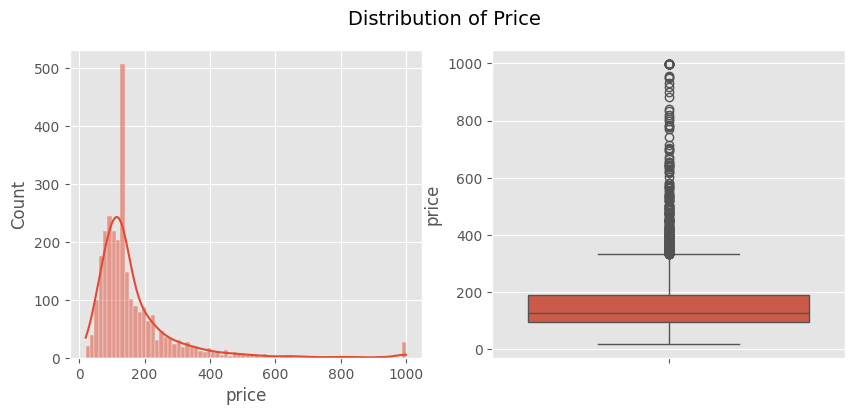

In [22]:
# Visualazing the review_per_month distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
ax.flatten()
sns.histplot(x = recent_listings["price"], ax = ax[0], kde = True)

sns.boxplot(y = recent_listings["price"], ax =ax[1])

fig.suptitle("Distribution of Price", fontsize = 14)

plt.show()

The prevailing analysis and visualizations on the price column reveals that the price distribution is rightly skewed with some outliers (skew = 3.3 and kurtosis = 14). Most of the listings are relatively affordable (median = $128). However there are some expensive listings too which may possibly be luxury or premium apartments which is normal in this case.

The average and median price for all listings are `$169.00` and `$127.00` respectively.